In [1]:
# Sneha Dubey (W1618643)
# Dr. Chen
# CSCI 184
# 04/22/2024
# Homework 2 Code

In [2]:
import os
import graphviz
import itertools 
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [3]:
# CODE TO IMPLEMENT

def partition(x):
    partitions = {}
    uniqueX = np.unique(x)
    for ux in uniqueX:
        partitions[ux] = np.where(x == ux)[0]
    return partitions



def entropy(y):
    ENT = 0
    labels = np.unique(y)
    for l in labels:
        targetLabelCount = 0
        for index in range(0, len(y)):
            if y[index] == l:
                targetLabelCount += 1
        p = targetLabelCount / len(y)
        ENT -= p*np.log2(p)
    return ENT



def information_gain(x, y):
    pENT = entropy(y)
    partitions = partition(x)
    wcENT = 0
    
    for part in partitions.values():
        cENT = entropy(y[part])
        partW = len(part)/len(y)
        wcENT += partW*cENT
    IG = pENT - wcENT
    return IG



def id3(x, y, attribute_value_pairs=None, depth=0, max_depth=5):
    # first stopping condition
    if len(np.unique(y)) == 1:
        return np.unique(y)[0]
    
    # second stopping condition
    if attribute_value_pairs == None:
        mostCommonLabel = 0
        mclCount = 0
        for label in np.unique(y):
            currLabelCount = 0
            for obj in y:
                if obj == label:
                    currLabelCount += 1
            if currLabelCount > mclCount:
                mostCommonLabel = label
                mclCount = currLabelCount
        return mostCommonLabel
    
    # third stopping condition
    if depth == max_depth:
        mostCommonLabel = 0
        mclCount = 0
        for label in np.unique(y):
            currLabelCount = 0
            for obj in y:
                if obj == label:
                    currLabelCount += 1
            if currLabelCount > mclCount:
                mostCommonLabel = label
                mclCount = currLabelCount
        return mostCommonLabel
    
    # selecting the next-best attribute-value pair using information_gain()
    if len(attribute_value_pairs) == 0:
        mostCommonLabel = 0
        mclCount = 0
        for label in np.unique(y):
            currLabelCount = 0
            for obj in y:
                if obj == label:
                    currLabelCount += 1
            if currLabelCount > mclCount:
                mostCommonLabel = label
                mclCount = currLabelCount
        return mostCommonLabel
    
    bestAVP = ()
    maxIG = 0
    for avp in attribute_value_pairs:
        currIG = information_gain(x[:, avp[0]], y)
        if currIG >= maxIG:
            bestAVP = avp
            maxIG = currIG
    
    # getting all remaining attribute-value pairs
    otherAVP = []
    for avp in attribute_value_pairs:
        if avp != bestAVP:
            otherAVP.append(avp)

    # partitioning on bestAVP
    partitions = partition(x[:, bestAVP[0]])
    
    # recursive call to ID3
    tree = {}
    for part, members in partitions.items():
        if len(members) == 0:
            mostCommonLabel = 0
            mclCount = 0
            for label in np.unique(y):
                currLabelCount = 0
                for obj in y:
                    if obj == label:
                        currLabelCount += 1
                if currLabelCount > mclCount:
                    mostCommonLabel = label
                    mclCount = currLabelCount
            tree[(bestAVP[0], part, True)] = mostCommonLabel
        else:
            tree[(bestAVP[0], part, True)] = id3(x[members], y[members], otherAVP, depth + 1, max_depth)
    return tree



def predict_example(x, tree):
    if type(tree) == dict:
        for key, value in tree.items():
            attribute = key[0]
            aValue = key[1]
            if x[attribute] == aValue:
                if type(value) == dict:
                    return predict_example(x, value)
                else:
                    return value
            else:
                if (attribute, aValue, False) not in tree:
                    mostCommonLabel = 0
                    mclCount = 0
                    for label in np.unique(tree.values()):
                        currLabelCount = 0
                        for obj in tree.values():
                            if obj == label:
                                currLabelCount += 1
                        if currLabelCount > mclCount:
                            mostCommonLabel = label
                            mclCount = currLabelCount
                    return mostCommonLabel
                return predict_example(x, tree[(attribute, aValue, False)])
    else:
        return tree

def compute_error(y_true, y_pred):
    incorrect = 0
    n = len(y_pred)
    for (true, pred) in zip(y_true, y_pred):
        if true != pred:
            incorrect += 1
    error = incorrect/n
    return error

In [4]:
# DO NOT MODIFY THESE

def pretty_print(tree, depth=0):
    """
    Pretty prints the decision tree to the console. Use print(tree) to print the raw nested dictionary representation
    DO NOT MODIFY THIS FUNCTION!
    """
    if depth == 0:
        print('TREE')

    for index, split_criterion in enumerate(tree):
        sub_trees = tree[split_criterion]

        # Print the current node: split criterion
        print('|\t' * depth, end='')
        print('+-- [SPLIT: x{0} = {1} {2}]'.format(split_criterion[0], split_criterion[1], split_criterion[2]))

        # Print the children
        if type(sub_trees) is dict:
            pretty_print(sub_trees, depth + 1)
        else:
            print('|\t' * (depth + 1), end='')
            print('+-- [LABEL = {0}]'.format(sub_trees))

            

def render_dot_file(dot_string, save_file, image_format='png'):
    """
    Uses GraphViz to render a dot file. The dot file can be generated using
        * sklearn.tree.export_graphviz()' for decision trees produced by scikit-learn
        * to_graphviz() (function is in this file) for decision trees produced by  your code.
    Modify Path to your GraphViz executable if needed. DO NOT MODIFY OTHER PART OF THIS FUNCTION!
    """
    if type(dot_string).__name__ != 'str':
        raise TypeError('visualize() requires a string representation of a decision tree.\nUse tree.export_graphviz()'
                        'for decision trees produced by scikit-learn and to_graphviz() for decision trees produced by'
                        'your code.\n')

    # Set path to your GraphViz executable here
    os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
    graph = graphviz.Source(dot_string)
    graph.format = image_format
    graph.render(save_file, view=True)


    
def to_graphviz(tree, dot_string='', uid=-1, depth=0):
    """
    Converts a tree to DOT format for use with visualize/GraphViz
    DO NOT MODIFY THIS FUNCTION!
    """

    uid += 1       # Running index of node ids across recursion
    node_id = uid  # Node id of this node

    if depth == 0:
        dot_string += 'digraph TREE {\n'

    for split_criterion in tree:
        sub_trees = tree[split_criterion]
        attribute_index = split_criterion[0]
        attribute_value = split_criterion[1]
        split_decision = split_criterion[2]

        if not split_decision:
            # Alphabetically, False comes first
            dot_string += '    node{0} [label="x{1} = {2}?"];\n'.format(node_id, attribute_index, attribute_value)

        if type(sub_trees) is dict:
            if not split_decision:
                dot_string, right_child, uid = to_graphviz(sub_trees, dot_string=dot_string, uid=uid, depth=depth + 1)
                dot_string += '    node{0} -> node{1} [label="False"];\n'.format(node_id, right_child)
            else:
                dot_string, left_child, uid = to_graphviz(sub_trees, dot_string=dot_string, uid=uid, depth=depth + 1)
                dot_string += '    node{0} -> node{1} [label="True"];\n'.format(node_id, left_child)

        else:
            uid += 1
            dot_string += '    node{0} [label="y = {1}"];\n'.format(uid, sub_trees)
            if not split_decision:
                dot_string += '    node{0} -> node{1} [label="False"];\n'.format(node_id, uid)
            else:
                dot_string += '    node{0} -> node{1} [label="True"];\n'.format(node_id, uid)

    if depth == 0:
        dot_string += '}\n'
        return dot_string
    else:
        return dot_string, node_id, uid

In [5]:
# REPORT PROBLEM 1: LEARNING CURVE

Average Train Error for File 1:  26.612903225806456 %
Average Test Error for File 1:  25.0 %


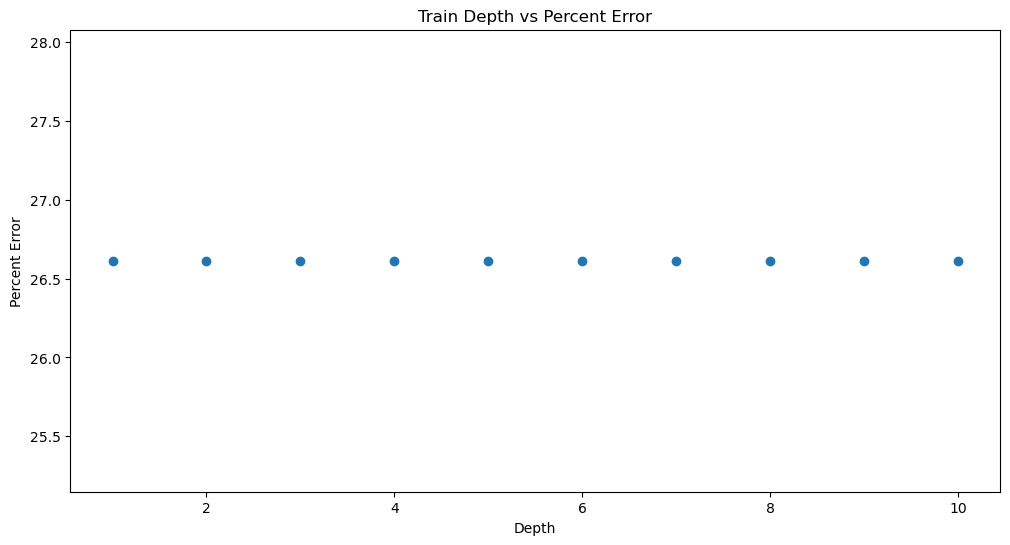

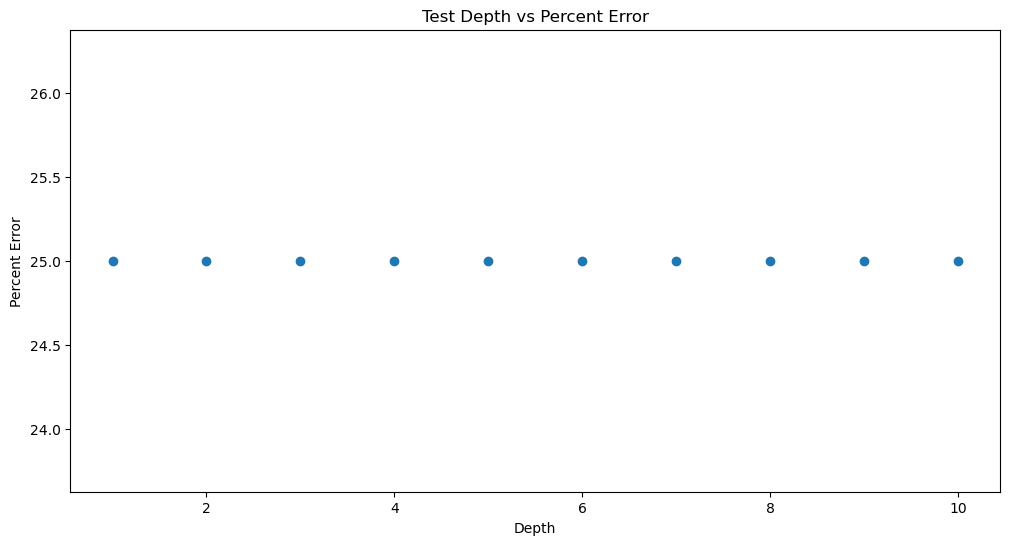

In [6]:
# Running on monks-1.train/test

# Load the training data
TR = np.genfromtxt('monks_data/monks-1.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytrn = TR[:, 0]
Xtrn = TR[:, 1:]

# Load the test data
TS = np.genfromtxt('monks_data/monks-1.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytst = TS[:, 0]
Xtst = TS[:, 1:]

# Get attribute_value_pair for the data
AVP = []
for obj in TR:
    for i in range(1, 6):
        if (i, obj[i]) not in AVP:
            AVP.append((i, obj[i]))

testError = 0
trainError = 0
trainDict = {}
testDict = {}
trainDict['Depth'] = []
trainDict['Percent Error'] = []
testDict['Depth'] = []
testDict['Percent Error'] = []

for i in range(1, 11):

    # Learn a decision tree of depth i
    decision_tree = id3(Xtrn, ytrn, AVP, 0, i)

    # Pretty print it to console
    #pretty_print(decision_tree)

    # Visualize the tree and save it as a PNG image
    #dot_str = to_graphviz(decision_tree)
    #render_dot_file(dot_str, './my_learned_tree')

    # Compute the train error
    y_trnpred = [predict_example(x, decision_tree) for x in Xtrn]
    trn_err = compute_error(ytrn, y_trnpred)

    # Compute the test error
    y_pred = [predict_example(x, decision_tree) for x in Xtst]
    tst_err = compute_error(ytst, y_pred)

    trainDict['Depth'].append(i)
    trainDict['Percent Error'].append(trn_err * 100)
    testDict['Depth'].append(i)
    testDict['Percent Error'].append(tst_err * 100)


    trainError += (trn_err * 100)
    testError += (tst_err * 100)


trainDF = pd.DataFrame.from_dict(trainDict)
testDF = pd.DataFrame.from_dict(testDict)

print('Average Train Error for File 1: ', trainError/10, "%")
print('Average Test Error for File 1: ', testError/10, "%")

plt.figure(figsize=(12, 6))
plt.plot(trainDF['Depth'], trainDF['Percent Error'], 'o')           # scatter plot showing actual data
plt.xlabel('Depth')
plt.ylabel('Percent Error')
plt.title('Train Depth vs Percent Error')

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(testDF['Depth'], testDF['Percent Error'], 'o')           # scatter plot showing actual data
plt.xlabel('Depth')
plt.ylabel('Percent Error')
plt.title('Test Depth vs Percent Error')

plt.show()


Average Train Error for File 2:  37.86982248520711 %
Average Test Error for File 2:  32.870370370370374 %


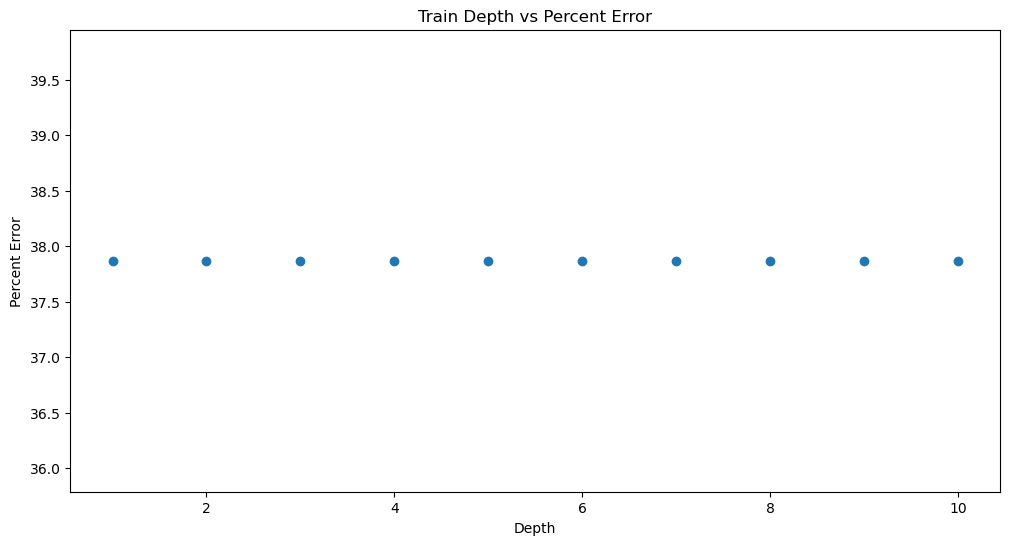

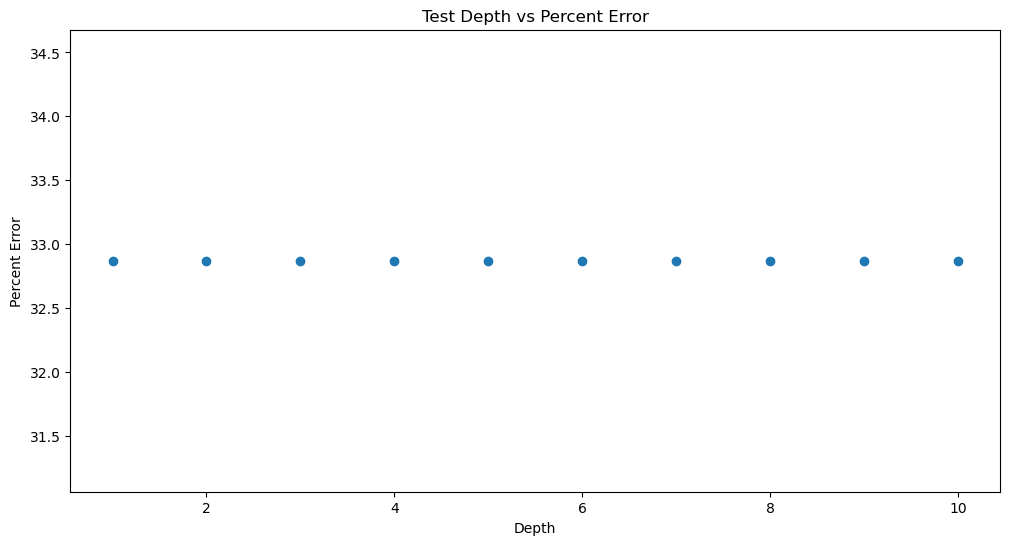

In [7]:
# Running on monks-2.train/test

# Load the training data
TR = np.genfromtxt('monks_data/monks-2.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytrn = TR[:, 0]
Xtrn = TR[:, 1:]

# Load the test data
TS = np.genfromtxt('monks_data/monks-2.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytst = TS[:, 0]
Xtst = TS[:, 1:]

# Get attribute_value_pair for the data
AVP = []
for obj in TR:
    for i in range(1, 6):
        if (i, obj[i]) not in AVP:
            AVP.append((i, obj[i]))

testError = 0
trainError = 0
trainDict = {}
testDict = {}
trainDict['Depth'] = []
trainDict['Percent Error'] = []
testDict['Depth'] = []
testDict['Percent Error'] = []

for i in range(1, 11):

    # Learn a decision tree of depth i
    decision_tree = id3(Xtrn, ytrn, AVP, 0, i)

    # Pretty print it to console
    #pretty_print(decision_tree)

    # Visualize the tree and save it as a PNG image
    #dot_str = to_graphviz(decision_tree)
    #render_dot_file(dot_str, './my_learned_tree')

    # Compute the train error
    y_trnpred = [predict_example(x, decision_tree) for x in Xtrn]
    trn_err = compute_error(ytrn, y_trnpred)

    # Compute the test error
    y_pred = [predict_example(x, decision_tree) for x in Xtst]
    tst_err = compute_error(ytst, y_pred)

    trainDict['Depth'].append(i)
    trainDict['Percent Error'].append(trn_err * 100)
    testDict['Depth'].append(i)
    testDict['Percent Error'].append(tst_err * 100)


    trainError += (trn_err * 100)
    testError += (tst_err * 100)


trainDF = pd.DataFrame.from_dict(trainDict)
testDF = pd.DataFrame.from_dict(testDict)

print('Average Train Error for File 2: ', trainError/10, "%")
print('Average Test Error for File 2: ', testError/10, "%")

plt.figure(figsize=(12, 6))
plt.plot(trainDF['Depth'], trainDF['Percent Error'], 'o')           # scatter plot showing actual data
plt.xlabel('Depth')
plt.ylabel('Percent Error')
plt.title('Train Depth vs Percent Error')

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(testDF['Depth'], testDF['Percent Error'], 'o')           # scatter plot showing actual data
plt.xlabel('Depth')
plt.ylabel('Percent Error')
plt.title('Test Depth vs Percent Error')

plt.show()


Average Train Error for File 3:  39.262295081967224 %
Average Test Error for File 3:  43.611111111111114 %


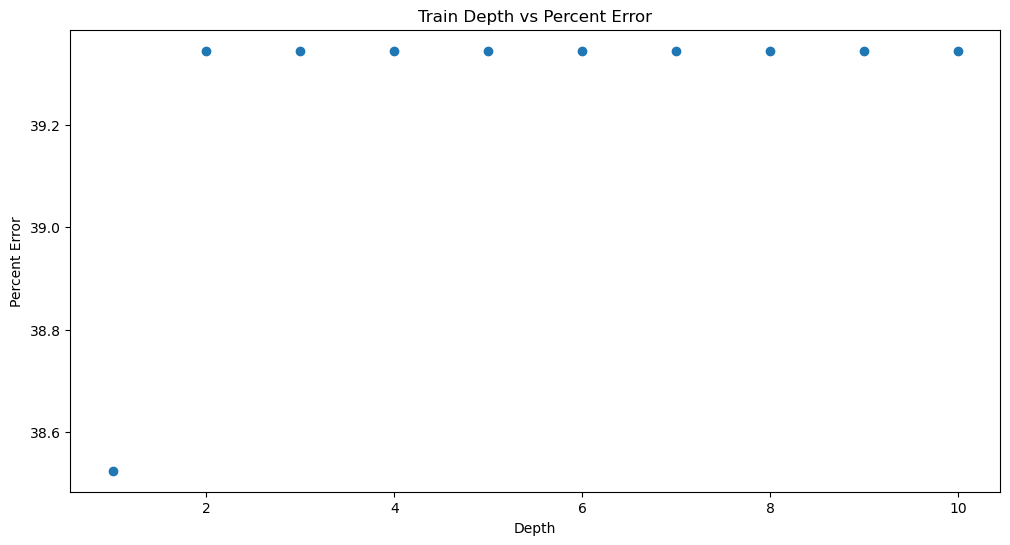

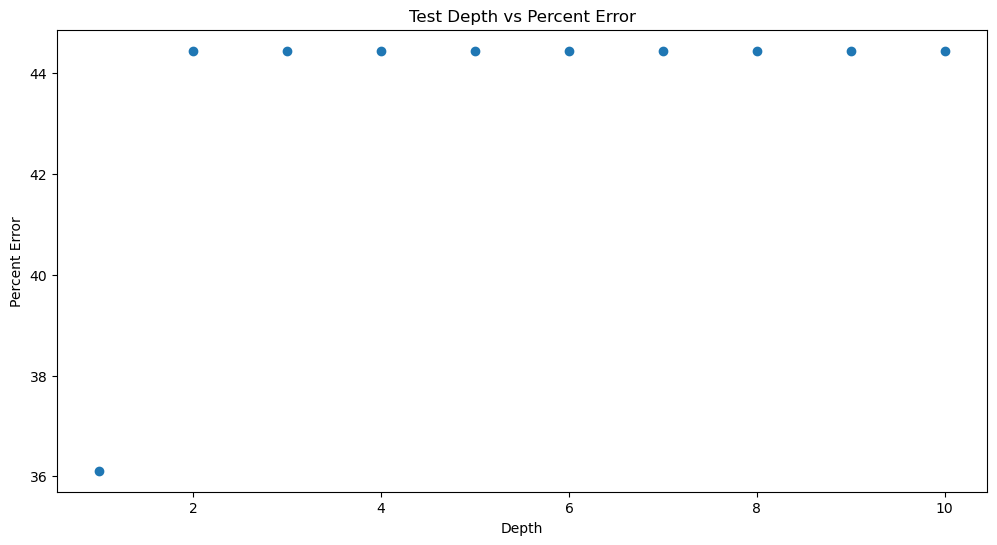

In [8]:
# Running on monks-3.train/test

# Load the training data
TR = np.genfromtxt('monks_data/monks-3.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytrn = TR[:, 0]
Xtrn = TR[:, 1:]

# Load the test data
TS = np.genfromtxt('monks_data/monks-3.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytst = TS[:, 0]
Xtst = TS[:, 1:]

# Get attribute_value_pair for the data
AVP = []
for obj in TR:
    for i in range(1, 6):
        if (i, obj[i]) not in AVP:
            AVP.append((i, obj[i]))

testError = 0
trainError = 0
trainDict = {}
testDict = {}
trainDict['Depth'] = []
trainDict['Percent Error'] = []
testDict['Depth'] = []
testDict['Percent Error'] = []

for i in range(1, 11):

    # Learn a decision tree of depth i
    decision_tree = id3(Xtrn, ytrn, AVP, 0, i)

    # Pretty print it to console
    #pretty_print(decision_tree)

    # Visualize the tree and save it as a PNG image
    #dot_str = to_graphviz(decision_tree)
    #render_dot_file(dot_str, './my_learned_tree')

    # Compute the train error
    y_trnpred = [predict_example(x, decision_tree) for x in Xtrn]
    trn_err = compute_error(ytrn, y_trnpred)

    # Compute the test error
    y_pred = [predict_example(x, decision_tree) for x in Xtst]
    tst_err = compute_error(ytst, y_pred)

    trainDict['Depth'].append(i)
    trainDict['Percent Error'].append(trn_err * 100)
    testDict['Depth'].append(i)
    testDict['Percent Error'].append(tst_err * 100)


    trainError += (trn_err * 100)
    testError += (tst_err * 100)


trainDF = pd.DataFrame.from_dict(trainDict)
testDF = pd.DataFrame.from_dict(testDict)

print('Average Train Error for File 3: ', trainError/10, "%")
print('Average Test Error for File 3: ', testError/10, "%")

plt.figure(figsize=(12, 6))
plt.plot(trainDF['Depth'], trainDF['Percent Error'], 'o')           # scatter plot showing actual data
plt.xlabel('Depth')
plt.ylabel('Percent Error')
plt.title('Train Depth vs Percent Error')

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(testDF['Depth'], testDF['Percent Error'], 'o')           # scatter plot showing actual data
plt.xlabel('Depth')
plt.ylabel('Percent Error')
plt.title('Test Depth vs Percent Error')

plt.show()


In [9]:
# REPORT QUESTION 2: WEAK LEARNERS

In [10]:
# Running on monks-1.train/test

# Load the test data
TS = np.genfromtxt('monks_data/monks-1.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytst = TS[:, 0]
Xtst = TS[:, 1:]

# Get attribute_value_pair for the data
AVP = []
for obj in TR:
    for i in range(1, 6):
        if (i, obj[i]) not in AVP:
            AVP.append((i, obj[i]))

for i in range(1, 6, 2):

    # Learn a decision tree of depth i
    decision_tree = id3(Xtrn, ytrn, AVP, 0, i)

    # Pretty print it to console
    print("----------------------------------------------------------------")
    print("Decision Tree with Depth of ", i, ": ")
    pretty_print(decision_tree)
    print("----------------------------------------------------------------")

    # Visualize the tree and save it as a PNG image
    print("----------------------------------------------------------------")
    print("To see the .png file of the visualised decision_tree, please visit my_learned_tree_of_depth_" + str(i) + ".png within this folder")
    dot_str = to_graphviz(decision_tree)
    render_dot_file(dot_str, './my_learned_tree_of_depth_' + str(i))
    print("----------------------------------------------------------------")

    # Compute the confusion matrix
    print("----------------------------------------------------------------")
    print("Confusion Matrix for Depth = ", i, ":")
    y_pred = [predict_example(x, decision_tree) for x in Xtst]
    print(confusion_matrix(ytst, y_pred))
    print("----------------------------------------------------------------")

----------------------------------------------------------------
Decision Tree with Depth of  1 : 
TREE
+-- [SPLIT: x1 = 1 True]
|	+-- [LABEL = 1]
+-- [SPLIT: x1 = 2 True]
|	+-- [LABEL = 1]
+-- [SPLIT: x1 = 3 True]
|	+-- [LABEL = 0]
----------------------------------------------------------------
----------------------------------------------------------------
To see the .png file of the visualised decision_tree, please visit my_learned_tree_of_depth_1.png within this folder
----------------------------------------------------------------
----------------------------------------------------------------
Confusion Matrix for Depth =  1 :
[[144  72]
 [144  72]]
----------------------------------------------------------------
----------------------------------------------------------------
Decision Tree with Depth of  3 : 
TREE
+-- [SPLIT: x1 = 1 True]
|	+-- [SPLIT: x4 = 1 True]
|	|	+-- [LABEL = 1]
|	+-- [SPLIT: x4 = 2 True]
|	|	+-- [LABEL = 1]
|	+-- [SPLIT: x4 = 3 True]
|	|	+-- [SPLIT: x3

In [11]:
# REPORT QUESTION 3: WEAK LEARNERS

----------------------------------------------------------------
To see the .png file of the visualised decision_tree, please visit scikit-learn_tree_of_depth_1.png within this folder


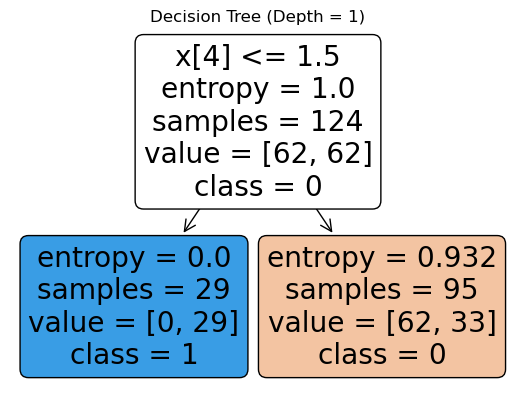

----------------------------------------------------------------
----------------------------------------------------------------
Confusion Matrix for Depth =  1 :
[[216   0]
 [108 108]]
----------------------------------------------------------------
----------------------------------------------------------------
To see the .png file of the visualised decision_tree, please visit scikit-learn_tree_of_depth_3.png within this folder


<Figure size 640x480 with 0 Axes>

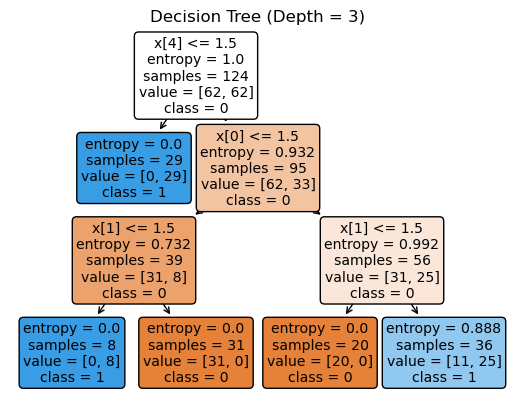

----------------------------------------------------------------
----------------------------------------------------------------
Confusion Matrix for Depth =  3 :
[[144  72]
 [  0 216]]
----------------------------------------------------------------
----------------------------------------------------------------
To see the .png file of the visualised decision_tree, please visit scikit-learn_tree_of_depth_5.png within this folder


<Figure size 640x480 with 0 Axes>

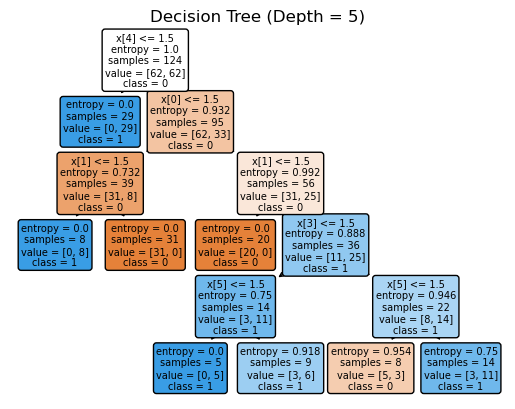

----------------------------------------------------------------
----------------------------------------------------------------
Confusion Matrix for Depth =  5 :
[[168  48]
 [ 24 192]]
----------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [12]:
# Running on monks-1.train/test

# Load the training data
TR = np.genfromtxt('monks_data/monks-1.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytrn = TR[:, 0]
Xtrn = TR[:, 1:]

# Load the test data
TS = np.genfromtxt('monks_data/monks-1.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytst = TS[:, 0]
Xtst = TS[:, 1:]

# Get attribute_value_pair for the data
AVP = []
for obj in TR:
    for i in range(1, 6):
        if (i, obj[i]) not in AVP:
            AVP.append((i, obj[i]))

for i in range(1, 6, 2):

    # Learn a decision tree of depth i
    decision_tree = DecisionTreeClassifier(criterion = "entropy", max_depth = i)
    decision_tree.fit(Xtrn, ytrn)

    # Visualize the tree and save it as a PNG image
    print("----------------------------------------------------------------")
    print("To see the .png file of the visualised decision_tree, please visit scikit-learn_tree_of_depth_" + str(i) + ".png within this folder")
    plt.figure()
    plot_tree(decision_tree, filled=True, rounded=True, class_names=['0', '1'])
    plt.title(f'Decision Tree (Depth = {i})')
    plt.show()
    plt.savefig(f'scikit-learn_tree_of_depth_{i}.png')
    print("----------------------------------------------------------------")

    print("----------------------------------------------------------------")
    print("Confusion Matrix for Depth = ", i, ":")
    y_pred = decision_tree.predict(Xtst)
    cm = confusion_matrix(ytst, y_pred)
    print(cm)
    print("----------------------------------------------------------------")